In [3]:
import numpy as np
import os
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import collections

from environment_multi import MazeEnvironment

Transition = collections.namedtuple('Experience',
                                    field_names=['state', 'action',
                                                 'next_state', 'reward',
                                                 'is_game_on'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.memory)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size, device = 'cuda'):
        indices = np.random.choice(len(self.memory), batch_size, replace = False)
        
        states, actions, next_states, rewards, isgameon = zip(*[self.memory[idx] 
                                                                for idx in indices])
        
        return torch.Tensor(states).type(torch.float).to(device), \
               torch.Tensor(actions).type(torch.long).to(device), \
               torch.Tensor(next_states).to(device), \
               torch.Tensor(rewards).to(device), torch.tensor(isgameon).to(device)
    

class fc_nn(nn.Module):
    def __init__(self, Ni, Nh1, Nh2, No = 4):
        super().__init__()
        
        self.fc1 = nn.Linear(Ni, Nh1)
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, No)
        
        self.act = nn.ReLU()
        
    def forward(self, x, classification = False, additional_out=False):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        out = self.fc3(x)
        
        return out
    
def Qloss(batch, net, gamma=0.99, device="cuda"):
    states, actions, next_states, rewards, _ = batch
    lbatch = len(states)
    state_action_values = net(states.view(lbatch, 2, -1))
    state_action_values = state_action_values.gather(1, actions.unsqueeze(-1))
    state_action_values = state_action_values.squeeze(-1)
    
    next_state_values = net(next_states.view(lbatch, 2, -1))
    next_state_values = next_state_values.max(1)[0]
    
    next_state_values = next_state_values.detach()
    expected_state_action_values = next_state_values * gamma + rewards
    
    return nn.MSELoss()(state_action_values, expected_state_action_values)

output_dir = './results/3'
os.makedirs(output_dir, exist_ok=True)
#os.environ["CUDA_VISIBLE_DEVICES"] = "4"
maze = np.load('maze_generator/maze.npy')

initial_position = [0,0]
goal1 = np.asarray([len(maze)-1, len(maze)-1])
goal2 = np.asarray([17, 17])
goal3 = np.asarray([18, 9])
goal = []
goal.append(goal1)
goal.append(goal2)
goal.append(goal3)
maze_env = MazeEnvironment(maze, initial_position, goal)
buffer_capacity = 10000
buffer_start_size = 1000
memory_buffer = ExperienceReplay(buffer_capacity)

from agent_multi import Agent
agent = Agent(maze = maze_env,
              memory_buffer = memory_buffer,
              use_softmax = True
             )

#net = fc_nn_multi(maze.size, maze.size, maze.size, 4)
net = fc_nn(maze.size, maze.size, maze.size, 4)
net.load_state_dict(torch.load('./results/3/best.torch'))
net.to('cuda')


fc_nn(
  (fc1): Linear(in_features=400, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=4, bias=True)
  (act): ReLU()
)

KeyboardInterrupt: 

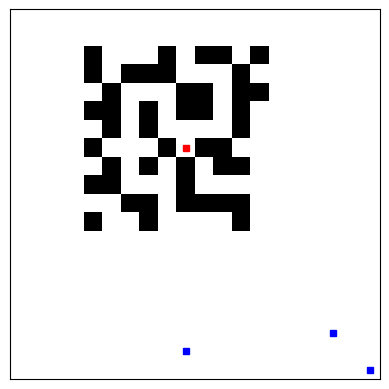

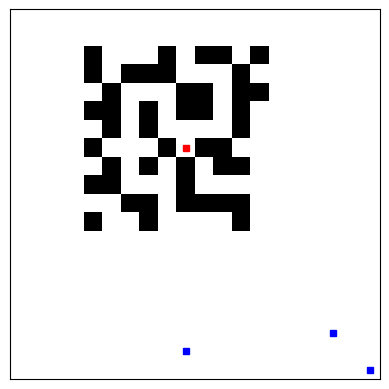

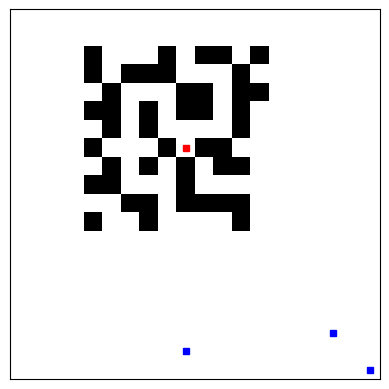

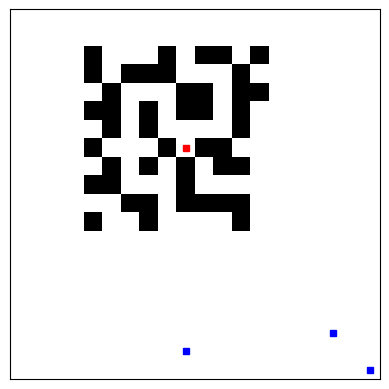

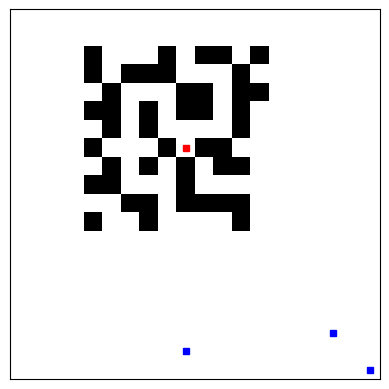

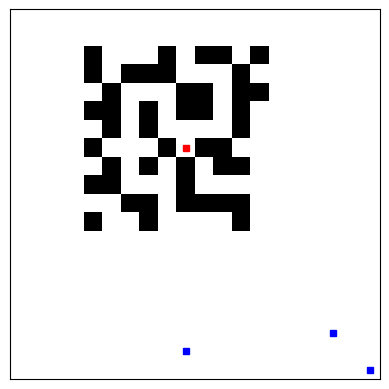

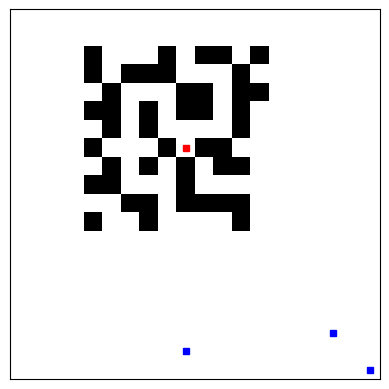

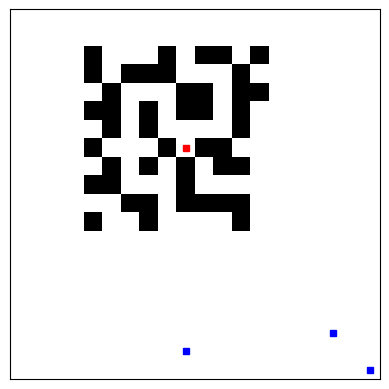

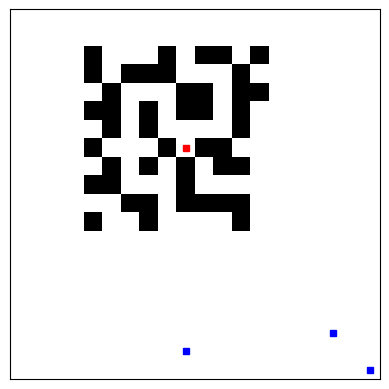

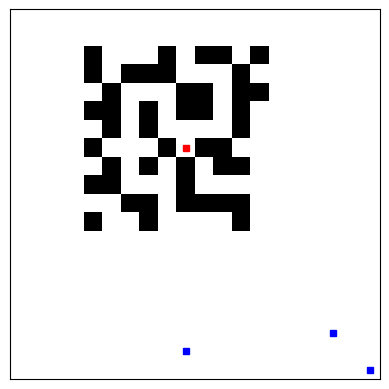

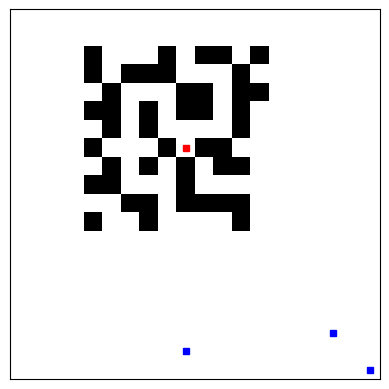

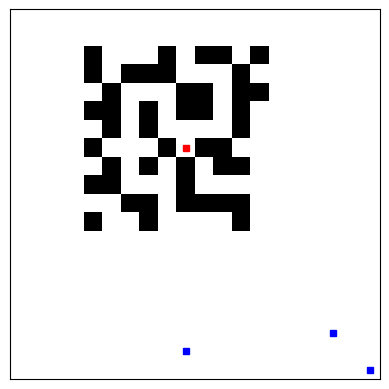

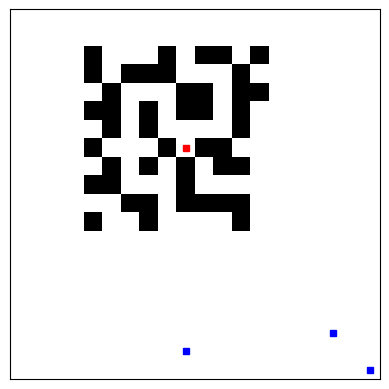

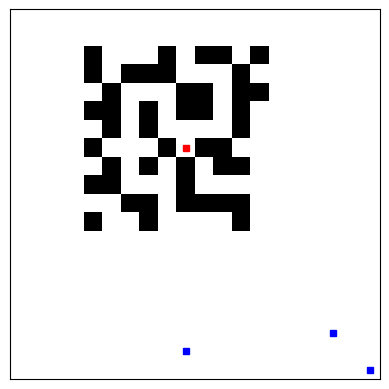

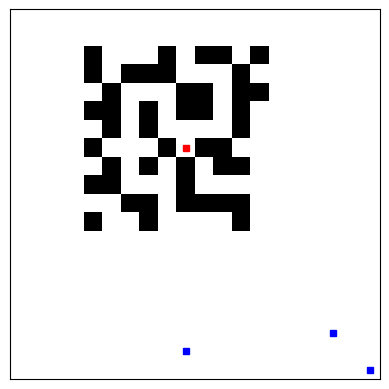

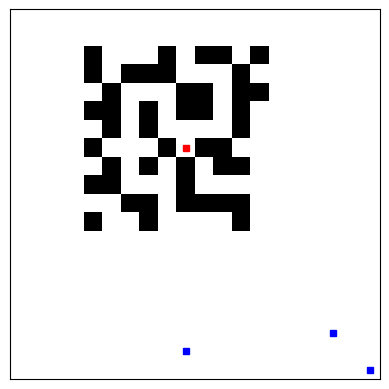

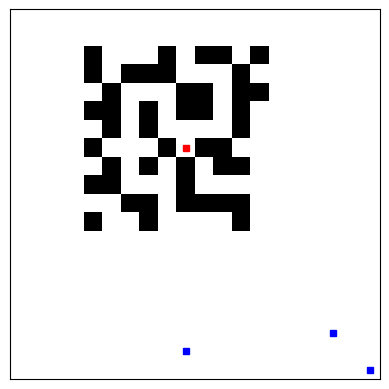

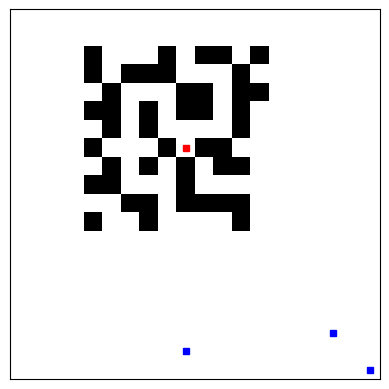

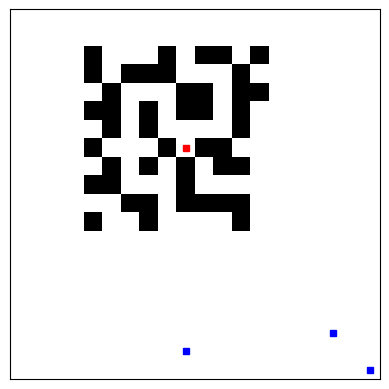

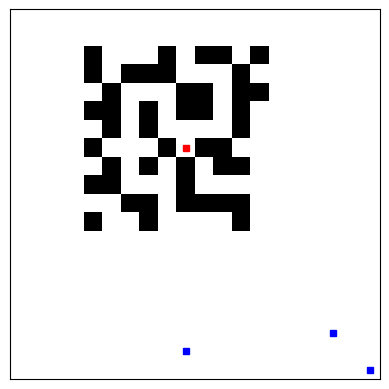

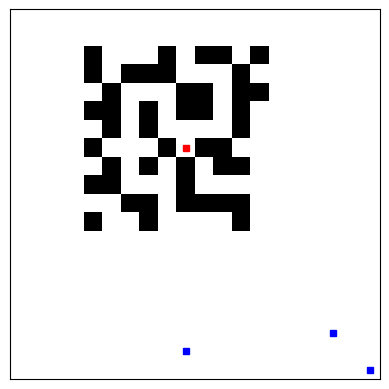

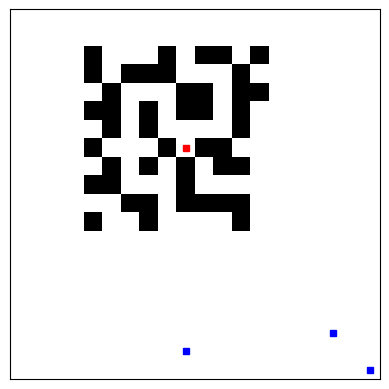

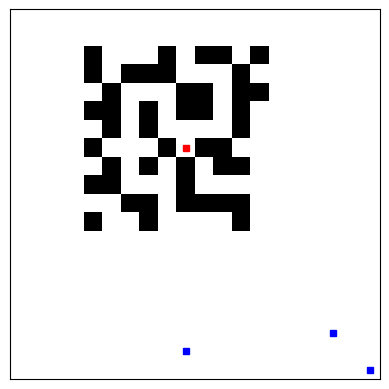

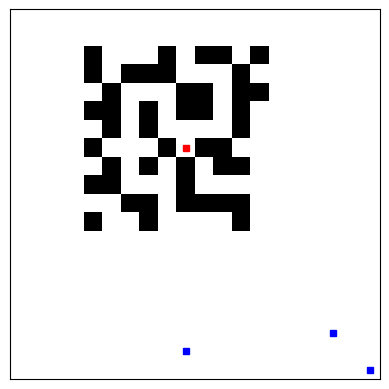

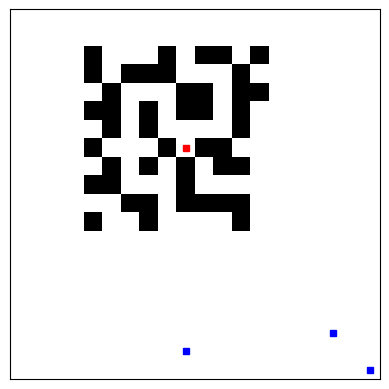

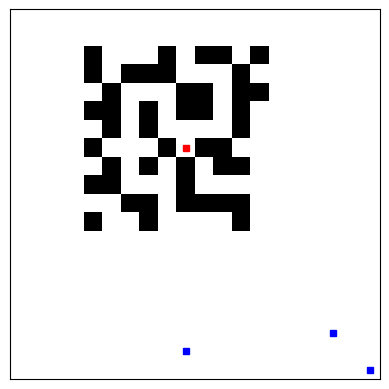

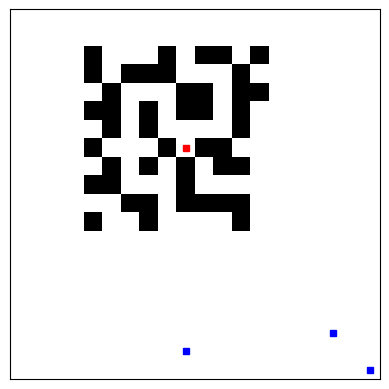

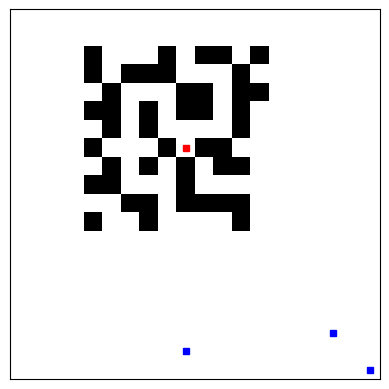

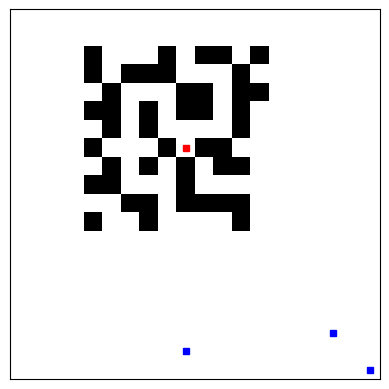

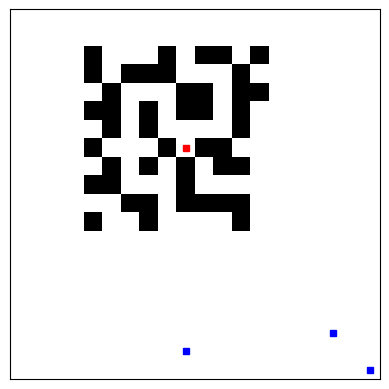

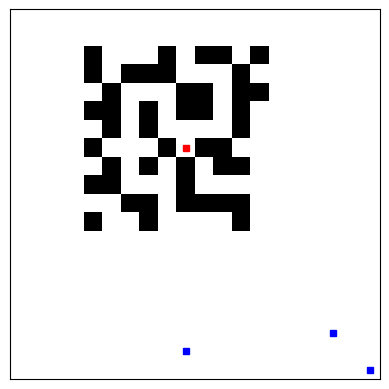

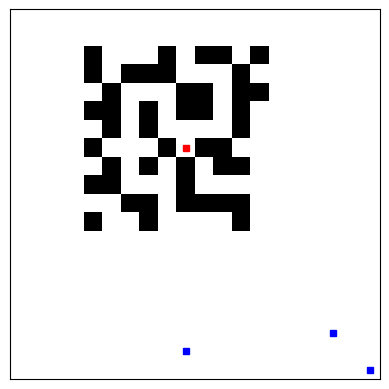

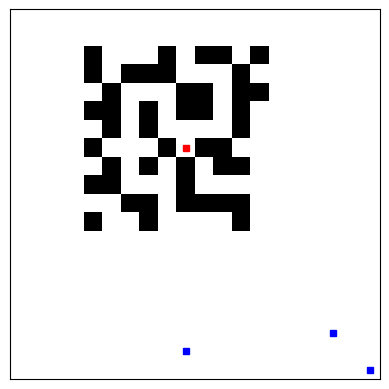

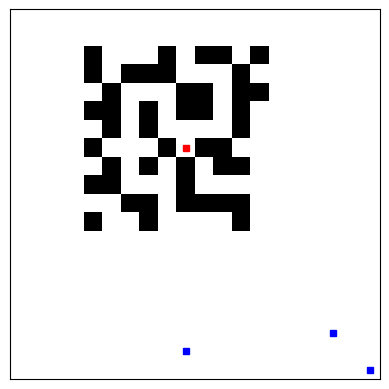

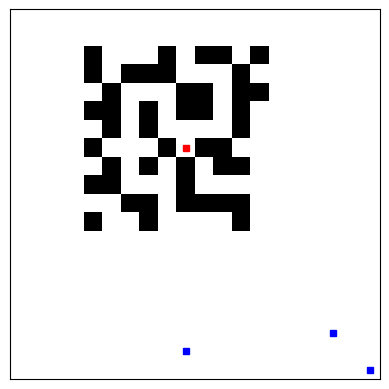

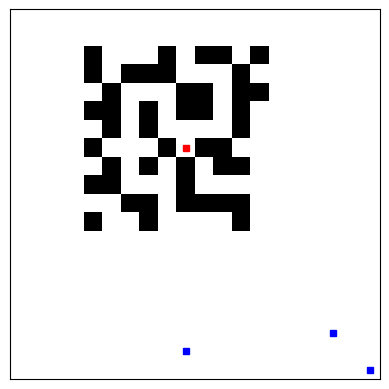

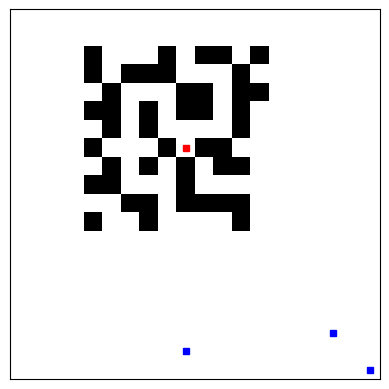

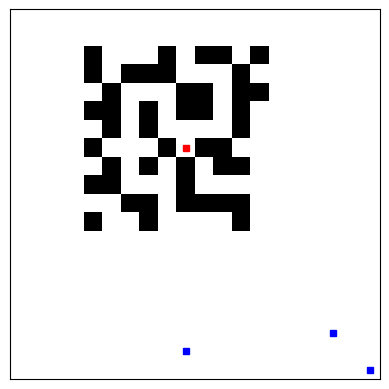

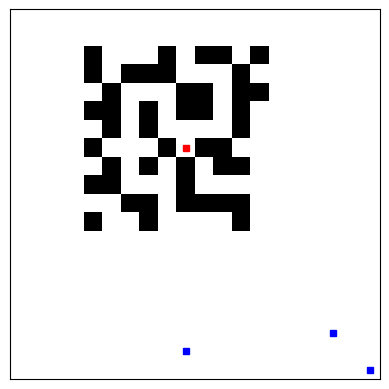

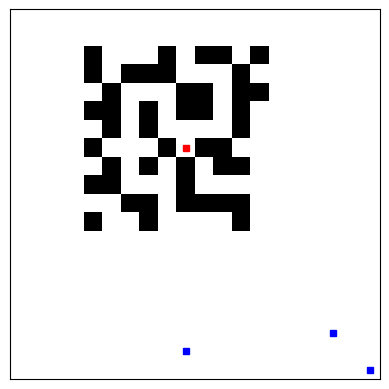

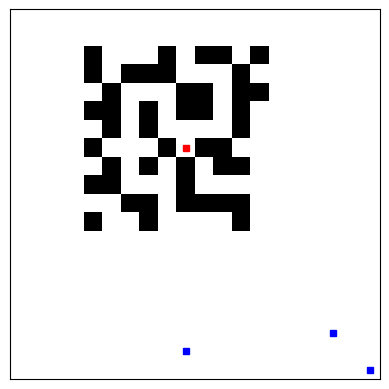

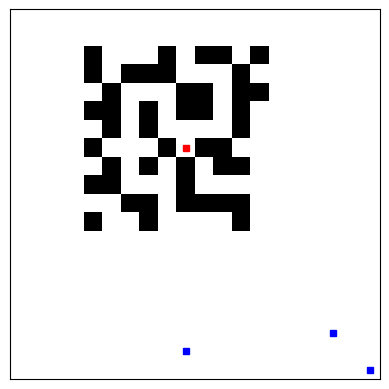

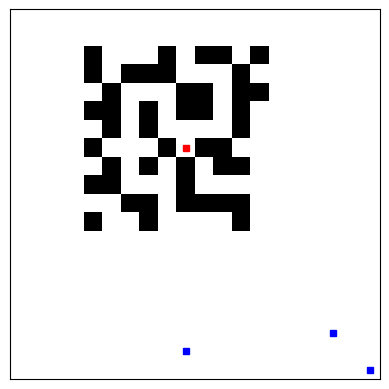

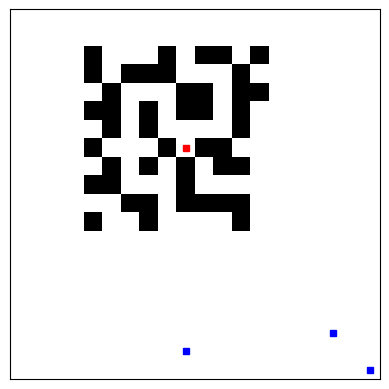

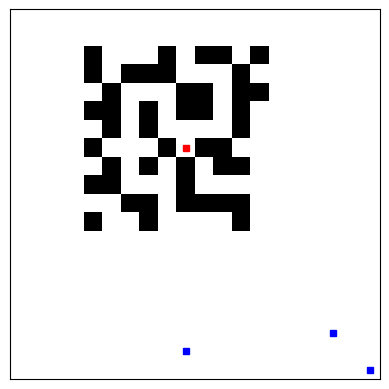

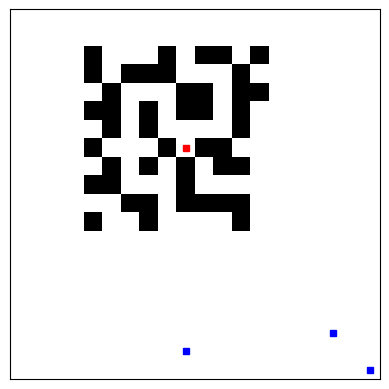

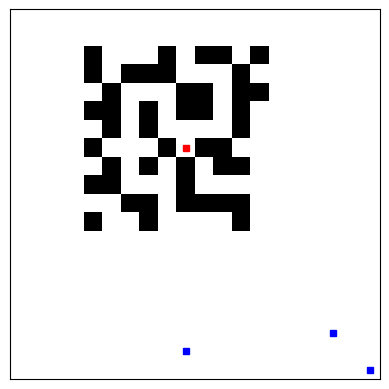

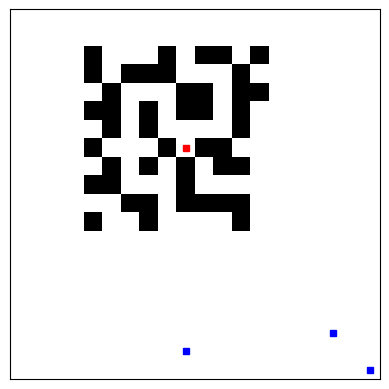

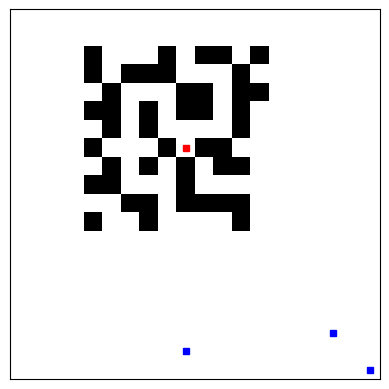

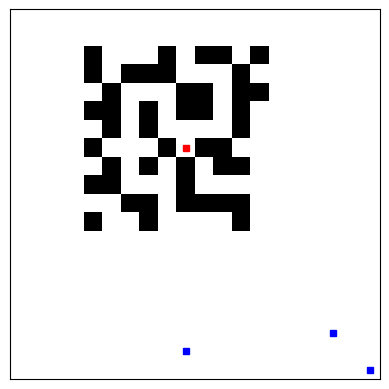

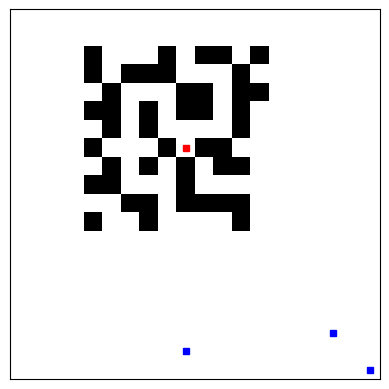

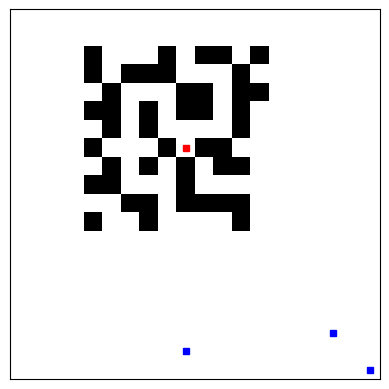

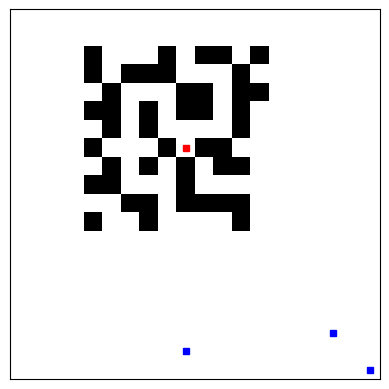

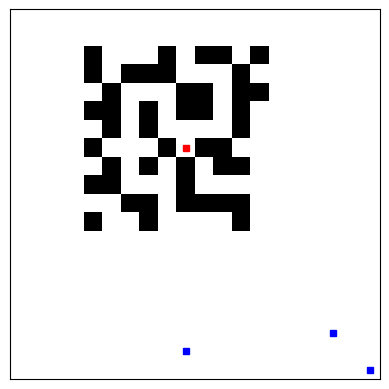

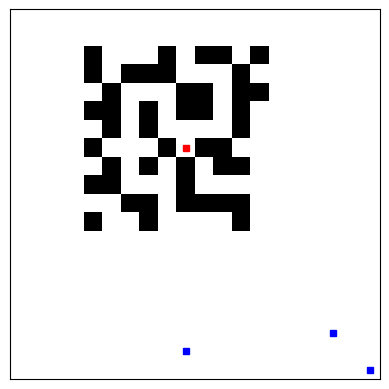

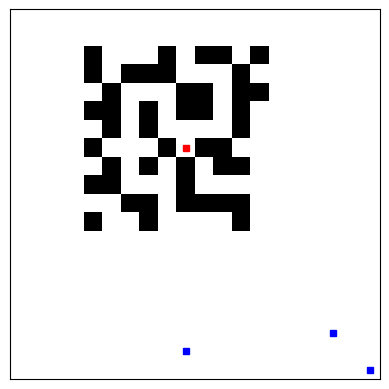

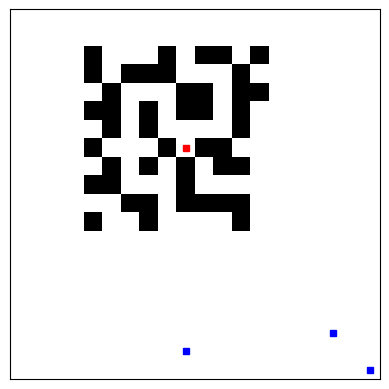

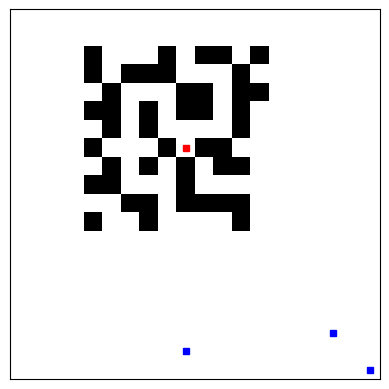

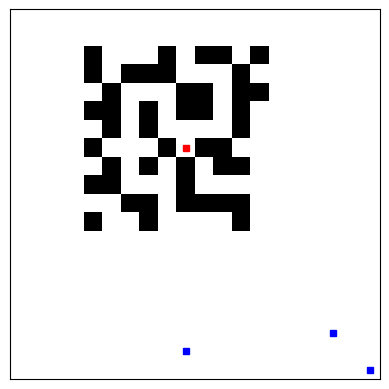

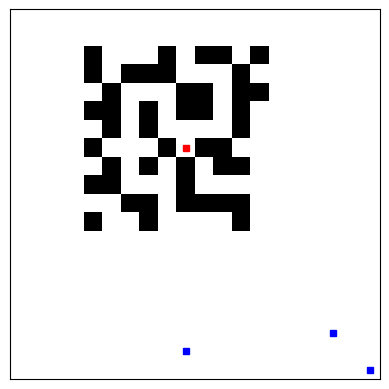

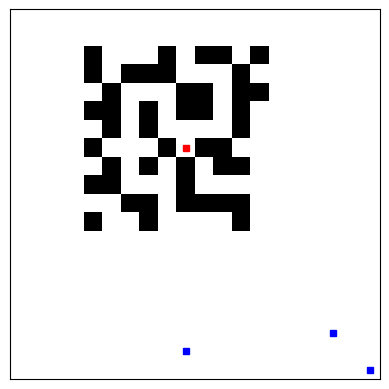

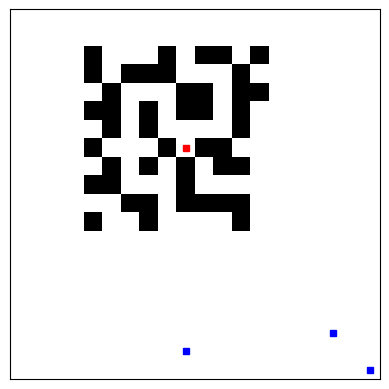

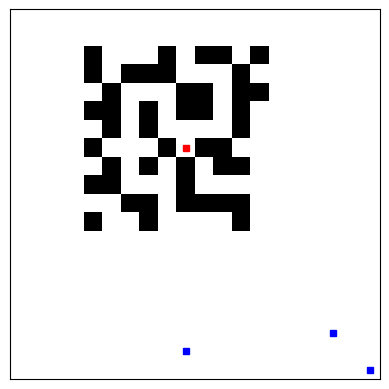

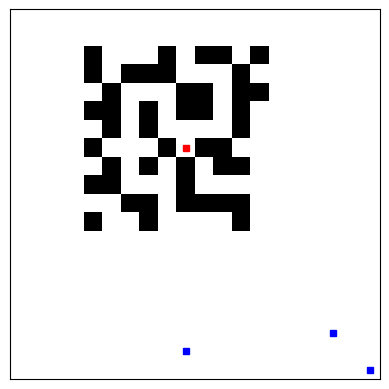

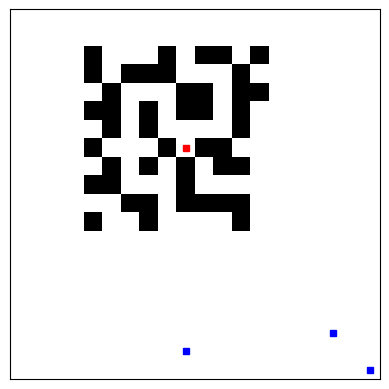

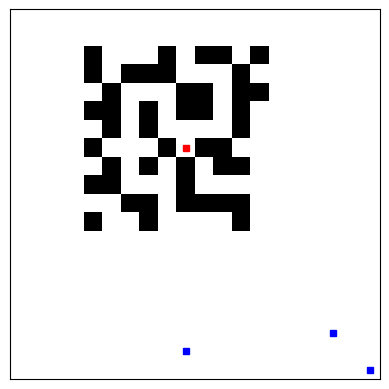

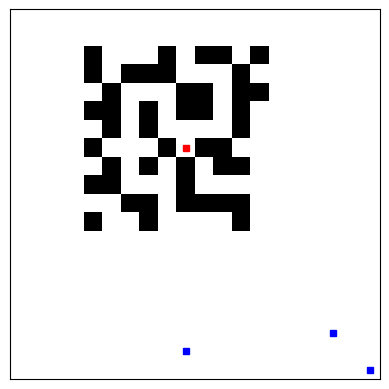

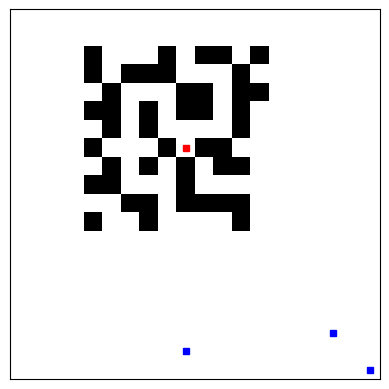

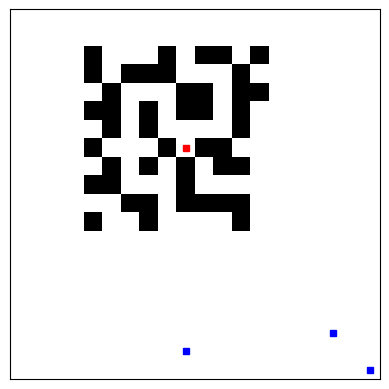

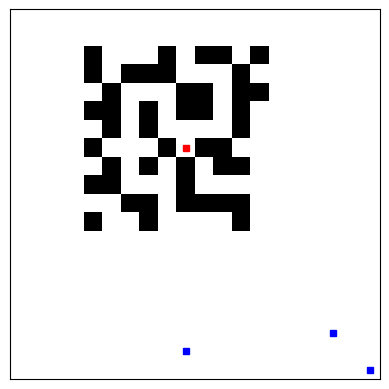

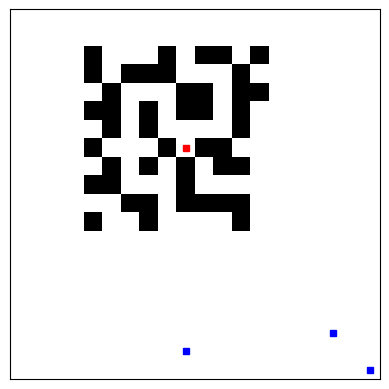

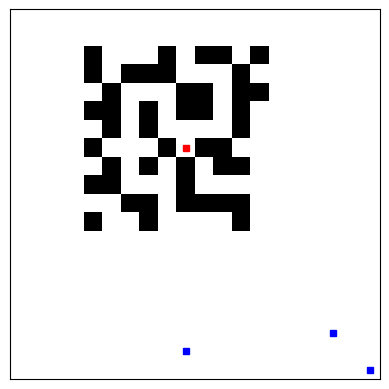

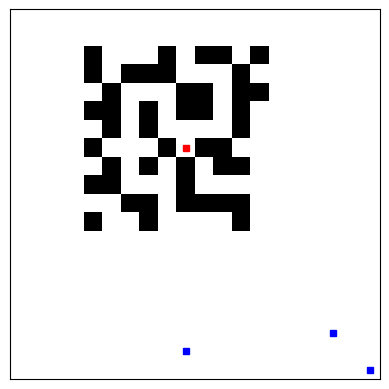

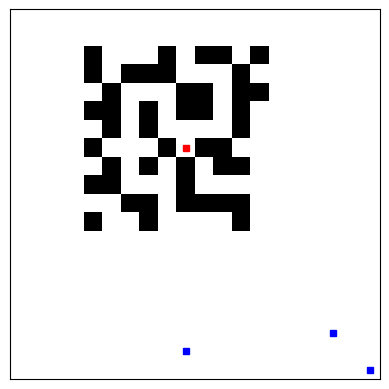

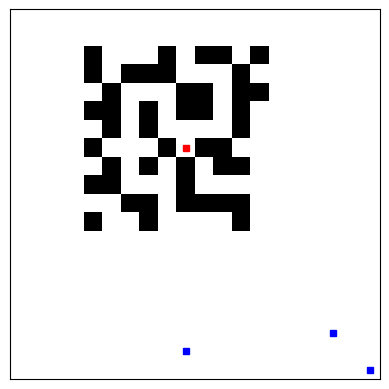

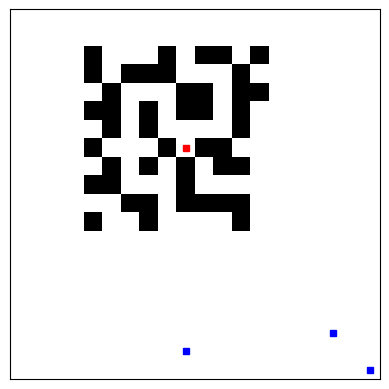

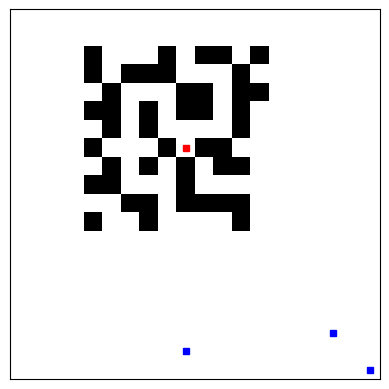

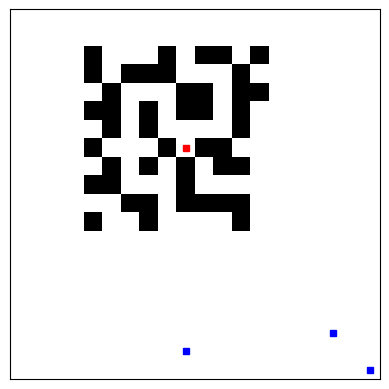

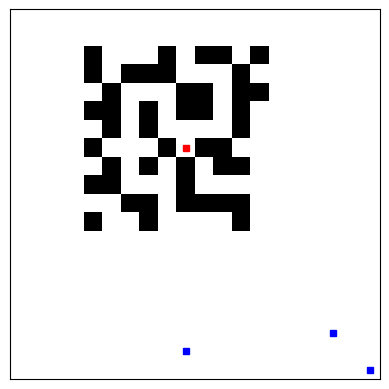

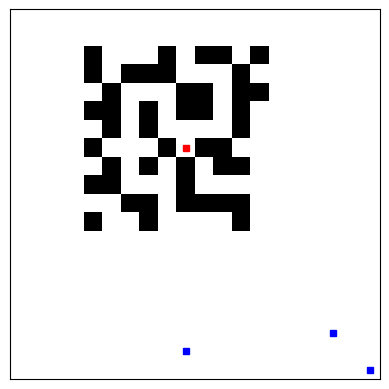

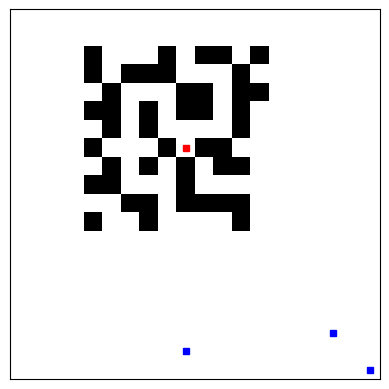

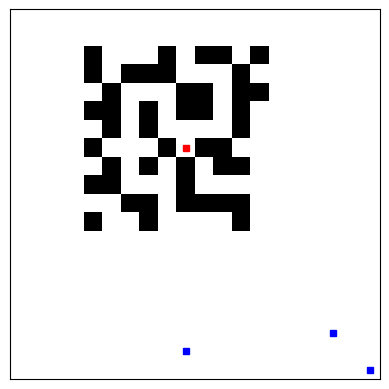

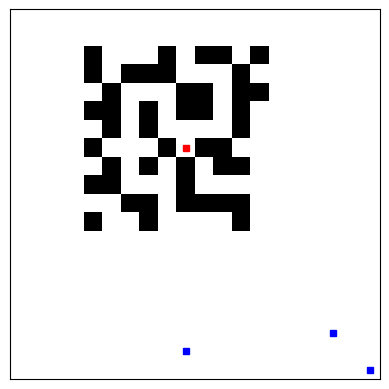

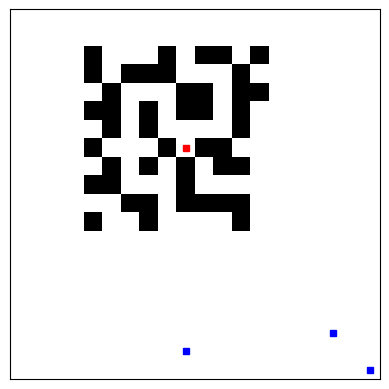

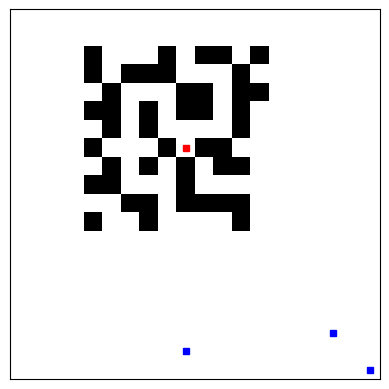

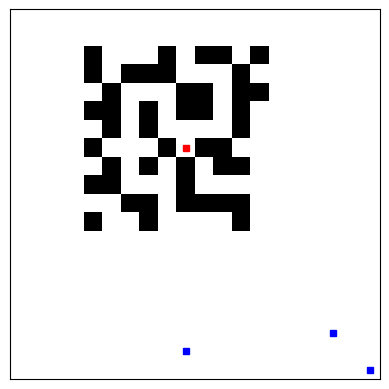

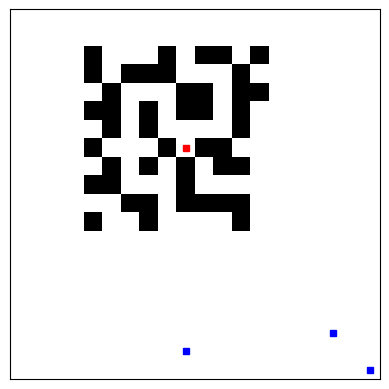

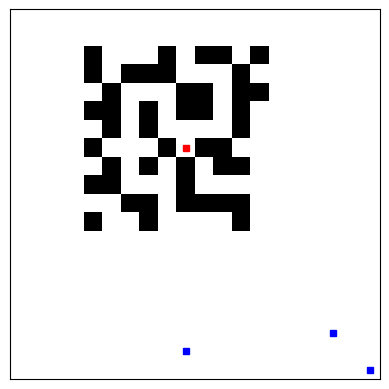

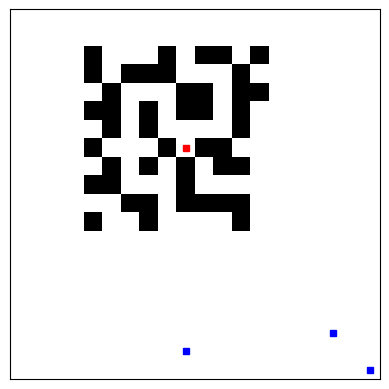

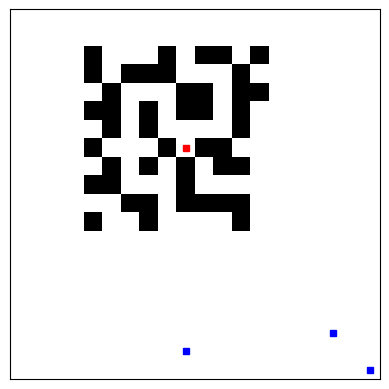

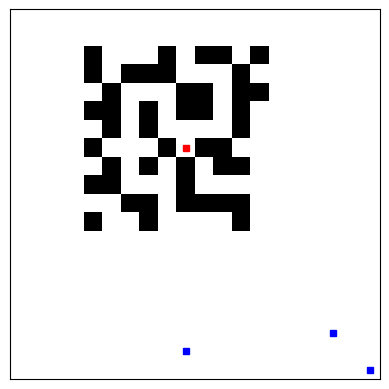

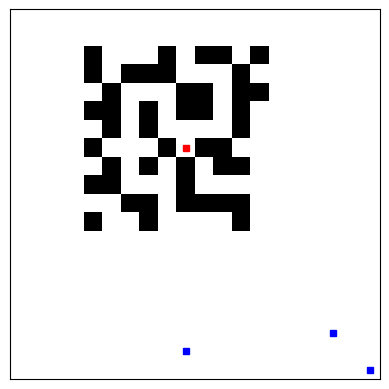

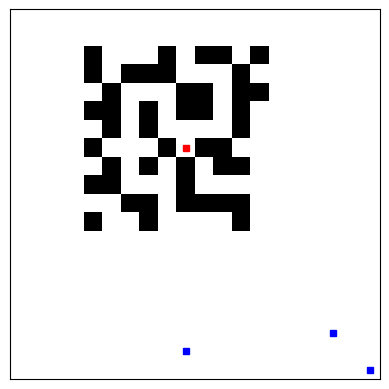

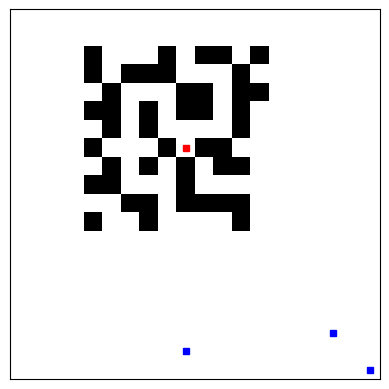

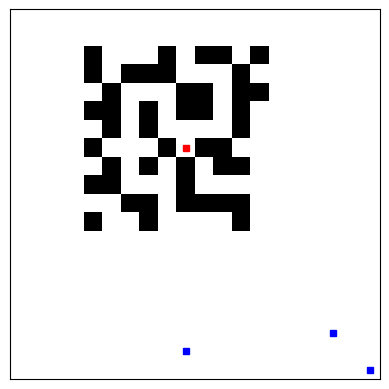

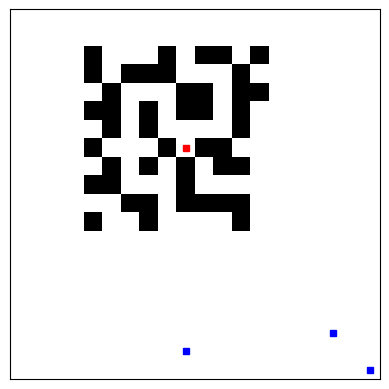

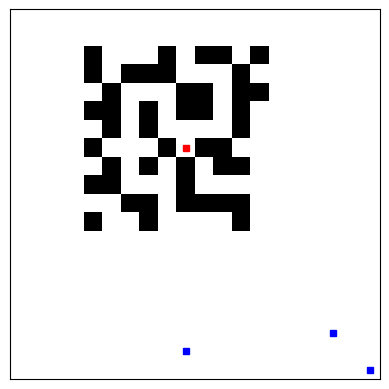

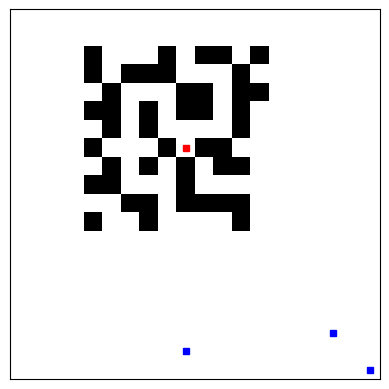

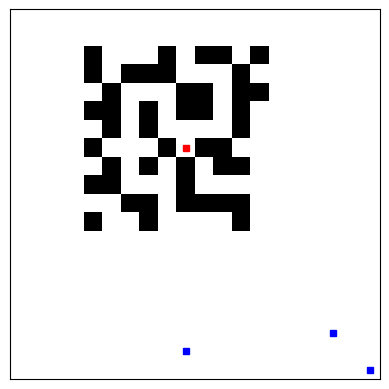

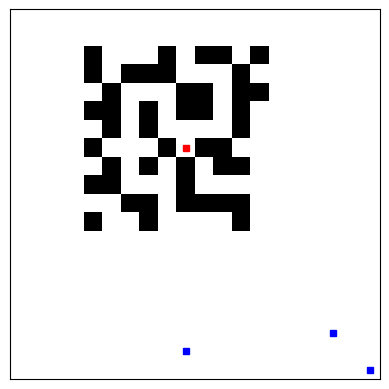

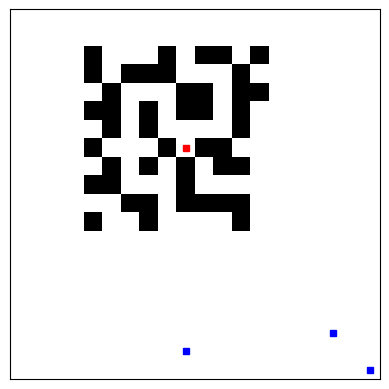

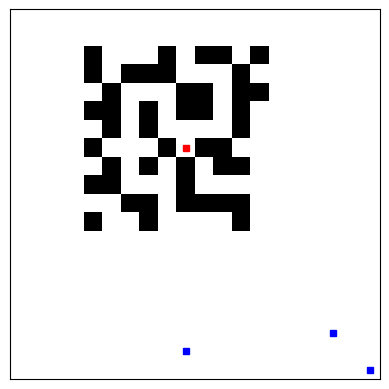

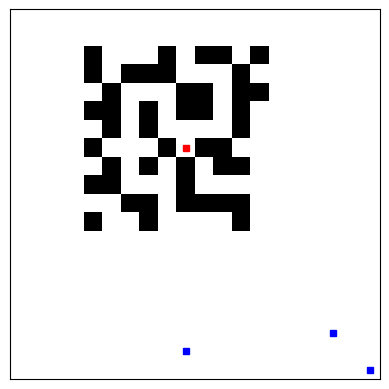

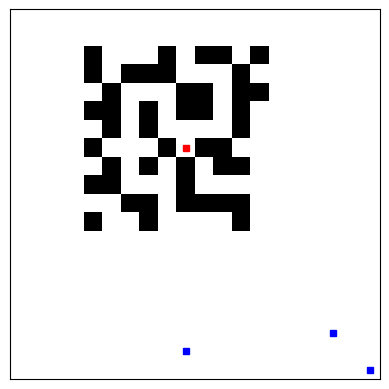

In [5]:
net.eval()
agent.isgameon = True
agent.use_softmax = False
_ = agent.env.reset(0)
while agent.isgameon:
    agent.make_a_move(net, 0)
    agent.env.draw('')
    clear_output(wait = True)